# Flagrant Foul Impact on Point Differential (2023-24 Season)

Linear regression with continuous outcome: Does committing a flagrant foul worsen point differential?

Model: point_differential ~ committed_flagrant_foul

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import t, norm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Set visualization style
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

## 1. Load and Prepare Data

In [2]:
# Load raw game data
csv_file = Path('nba_flagrant_fouls.csv')

if not csv_file.exists():
    print(f"Error: {csv_file} not found")
else:
    # Load with dtype to preserve game_id string format
    games_with_data = pd.read_csv(csv_file, dtype={'game_id': str})
    print(f"Loaded {len(games_with_data)} games from CSV")
    print(f"Columns: {games_with_data.columns.tolist()}")

Loaded 2282 games from CSV
Columns: ['game_id', 'home_team', 'away_team', 'home_flagrants', 'away_flagrants', 'home_score', 'away_score']


In [3]:
# Create long-format dataset: one row per team per game
home_data = games_with_data[['game_id', 'home_team', 'home_flagrants', 'home_score', 'away_score']].copy()
home_data.columns = ['game_id', 'team_id', 'committed_flagrant', 'team_score', 'opp_score']
home_data['location'] = 'home'

away_data = games_with_data[['game_id', 'away_team', 'away_flagrants', 'away_score', 'home_score']].copy()
away_data.columns = ['game_id', 'team_id', 'committed_flagrant', 'team_score', 'opp_score']
away_data['location'] = 'away'

# Combine home and away
df = pd.concat([home_data, away_data], ignore_index=True)

# Create continuous outcome: point differential
df['point_differential'] = df['team_score'] - df['opp_score']

# Convert flagrant count to binary (committed at least one flagrant foul)
df['committed_flagrant'] = (df['committed_flagrant'] > 0).astype(int)

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))


Dataset shape: (4564, 7)

First few rows:
      game_id     team_id  committed_flagrant  team_score  opp_score location  \
0  0042300405  1610612738                   0       106.0       88.0     home   
1  0042300404  1610612742                   0       122.0       84.0     home   
2  0042300403  1610612742                   0        99.0      106.0     home   
3  0042300402  1610612738                   0       105.0       98.0     home   
4  0042300401  1610612738                   0       107.0       89.0     home   
5  0042300315  1610612750                   1       103.0      124.0     home   
6  0042300314  1610612742                   0       100.0      105.0     home   
7  0042300304  1610612754                   0       102.0      105.0     home   
8  0042300313  1610612742                   0       116.0      107.0     home   
9  0042300303  1610612754                   0       111.0      114.0     home   

   point_differential  
0                18.0  
1                

## 2. Descriptive Statistics

In [4]:
# Summary statistics by flagrant status
print("\nPoint Differential by Flagrant Foul Status:")
print("="*70)

summary_stats = df.groupby('committed_flagrant')['point_differential'].agg([
    ('n', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('median', 'median')
])

summary_stats.index = ['No Flagrant', 'Committed Flagrant']
print(summary_stats)

# Calculate difference
mean_no_flagrant = df[df['committed_flagrant'] == 0]['point_differential'].mean()
mean_with_flagrant = df[df['committed_flagrant'] == 1]['point_differential'].mean()
difference = mean_no_flagrant - mean_with_flagrant

print(f"\nMean Difference: {difference:.2f} points")
print(f"  Teams WITHOUT flagrant: {mean_no_flagrant:+.2f} points")
print(f"  Teams WITH flagrant: {mean_with_flagrant:+.2f} points")
print(f"  → Teams with flagrant have {abs(difference):.2f} points {'worse' if difference > 0 else 'better'} differential")


Point Differential by Flagrant Foul Status:
                       n      mean        std   min   max  median
No Flagrant         4240  0.211792  15.753376 -60.0  60.0     1.0
Committed Flagrant   318 -2.823899  14.625087 -53.0  49.0    -5.0

Mean Difference: 3.04 points
  Teams WITHOUT flagrant: +0.21 points
  Teams WITH flagrant: -2.82 points
  → Teams with flagrant have 3.04 points worse differential


## 3. Power Calculation (Continuous Outcome)

In [5]:
# Calculate effect size (Cohen's d) for observed difference
group1 = df[df['committed_flagrant'] == 0]['point_differential']
group2 = df[df['committed_flagrant'] == 1]['point_differential']

# Pooled standard deviation
n1, n2 = len(group1), len(group2)
s1, s2 = group1.std(), group2.std()
pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

# Cohen's d
cohens_d = (group1.mean() - group2.mean()) / pooled_std

print("="*70)
print("POWER CALCULATION (Linear Regression)")
print("="*70)

print(f"\nEffect Size:")
print(f"  Cohen's d: {cohens_d:.4f}")
print(f"  Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small effect")
elif abs(cohens_d) < 0.5:
    print("Small-to-medium effect")
elif abs(cohens_d) < 0.8:
    print("Medium effect")
else:
    print("Large effect")

# Power calculation for independent samples t-test (equivalent to linear regression)
def power_t_test(effect_size, n1, n2, alpha=0.05, two_sided=True):
    """
    Calculate power for independent samples t-test.
    Equivalent to linear regression with binary predictor.
    """
    # Degrees of freedom
    df_error = n1 + n2 - 2
    
    # Critical t-value
    alpha_level = alpha / 2 if two_sided else alpha
    t_crit = t.ppf(1 - alpha_level, df_error)
    
    # Standard error of difference
    se_diff = np.sqrt(1/n1 + 1/n2)
    
    # Non-centrality parameter
    ncp = (effect_size / se_diff)
    
    # Power = P(|t| > t_crit) under alternative
    power = 1 - t.cdf(t_crit, df_error, ncp) + t.cdf(-t_crit, df_error, ncp)
    
    return power

# Calculate current power
current_power = power_t_test(cohens_d, n1, n2, alpha=0.05, two_sided=True)

print(f"\nCurrent Sample:")
print(f"  Total team-games: {len(df)}")
print(f"  Teams WITHOUT flagrant: {n1}")
print(f"  Teams WITH flagrant: {n2}")
print(f"  Statistical Power: {current_power:.3f} ({current_power*100:.1f}%)")
print(f"  Interpretation: {('ADEQUATE' if current_power >= 0.80 else 'INSUFFICIENT')} for 80% target")

# Calculate sample size needed for 80% power
def sample_size_for_power_t(effect_size, target_power=0.80, alpha=0.05):
    """
    Estimate sample size per group needed for target power.
    Uses Hedges & Olkin formula.
    """
    z_alpha = norm.ppf(1 - alpha/2)
    z_beta = norm.ppf(target_power)
    
    # For equal group sizes
    n_per_group = 2 * ((z_alpha + z_beta) / effect_size) ** 2
    
    return n_per_group

needed_per_group = sample_size_for_power_t(abs(cohens_d), target_power=0.80, alpha=0.05)
needed_total = needed_per_group * 2

print(f"\nSample Size Needed for 80% Power:")
print(f"  Per group: {int(np.ceil(needed_per_group))}")
print(f"  Total team-games: {int(np.ceil(needed_total))}")

current_coverage = (len(df) / needed_total) * 100
print(f"  Current coverage: {current_coverage:.1f}% of needed sample")

# Estimate seasons needed
team_games_per_season = len(df)
seasons_needed = needed_total / team_games_per_season

print(f"\nSeasonal Breakdown:")
print(f"  Team-games per season (2023-24): {team_games_per_season}")
print(f"  Seasons needed for 80% power: {seasons_needed:.2f}")

if seasons_needed <= 1:
    print(f"  → Current data is SUFFICIENT ✓")
elif seasons_needed <= 2:
    print(f"  → Need 2023-24 + one more season")
else:
    print(f"  → Need approximately {int(np.ceil(seasons_needed))} seasons of data")

POWER CALCULATION (Linear Regression)

Effect Size:
  Cohen's d: 0.1936
  Interpretation: Small effect

Current Sample:
  Total team-games: 4564
  Teams WITHOUT flagrant: 4246
  Teams WITH flagrant: 318
  Statistical Power: 0.915 (91.5%)
  Interpretation: ADEQUATE for 80% target

Sample Size Needed for 80% Power:
  Per group: 419
  Total team-games: 838
  Current coverage: 545.0% of needed sample

Seasonal Breakdown:
  Team-games per season (2023-24): 4564
  Seasons needed for 80% power: 0.18
  → Current data is SUFFICIENT ✓


## 4. Linear Regression Model

In [6]:
# Fit linear regression
model = ols('point_differential ~ committed_flagrant', data=df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     point_differential   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     11.09
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           0.000874
Time:                        18:21:18   Log-Likelihood:                -19011.
No. Observations:                4558   AIC:                         3.803e+04
Df Residuals:                    4556   BIC:                         3.804e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.2118      0

## 5. Model Results Extraction

In [7]:
# Extract key statistics
print("\n" + "="*70)
print("LINEAR REGRESSION RESULTS: Point Differential ~ Committed Flagrant Foul")
print("="*70)

# Get coefficients
intercept = model.params['Intercept']
flagrant_coef = model.params['committed_flagrant']
flagrant_se = model.bse['committed_flagrant']
flagrant_pval = model.pvalues['committed_flagrant']
flagrant_ci = model.conf_int().loc['committed_flagrant']

print(f"\n1. FLAGRANT FOUL EFFECT:")
print(f"  Coefficient: {flagrant_coef:.4f} points")
print(f"  Standard Error: {flagrant_se:.4f}")
print(f"  95% CI: [{flagrant_ci[0]:.4f}, {flagrant_ci[1]:.4f}]")
print(f"  P-value: {flagrant_pval:.4f}")
print(f"  Significance: {'Yes (p < 0.05)' if flagrant_pval < 0.05 else 'No (p >= 0.05)'}")

# Interpretation
print(f"\n  Interpretation:")
print(f"  Committing a flagrant foul is associated with a {flagrant_coef:.2f}-point")
print(f"  {'worse' if flagrant_coef < 0 else 'better'} point differential on average.")
if flagrant_pval < 0.05:
    print(f"  This effect is statistically significant (p = {flagrant_pval:.4f}).")
else:
    print(f"  This effect is not statistically significant (p = {flagrant_pval:.4f}).")

# Model fit
print(f"\n2. MODEL FIT:")
print(f"  R-squared: {model.rsquared:.4f}")
print(f"  Adj. R-squared: {model.rsquared_adj:.4f}")
print(f"  F-statistic: {model.fvalue:.4f}")
print(f"  Prob (F-statistic): {model.f_pvalue:.4f}")
print(f"  AIC: {model.aic:.2f}")
print(f"  BIC: {model.bic:.2f}")

# Residuals
print(f"\n3. RESIDUAL DIAGNOSTICS:")
print(f"  Residual Std. Error: {np.sqrt(model.mse_resid):.4f}")
print(f"  Durbin-Watson: {sm.stats.durbin_watson(model.resid):.4f}")

# Sample size
print(f"\n4. SAMPLE SIZE:")
print(f"  Total team-games: {len(df)}")
print(f"  Team-games with flagrant: {df['committed_flagrant'].sum()}")
print(f"  Team-games without flagrant: {(1-df['committed_flagrant']).sum()}")


LINEAR REGRESSION RESULTS: Point Differential ~ Committed Flagrant Foul

1. FLAGRANT FOUL EFFECT:
  Coefficient: -3.0357 points
  Standard Error: 0.9115
  95% CI: [-4.8227, -1.2487]
  P-value: 0.0009
  Significance: Yes (p < 0.05)

  Interpretation:
  Committing a flagrant foul is associated with a -3.04-point
  worse point differential on average.
  This effect is statistically significant (p = 0.0009).

2. MODEL FIT:
  R-squared: 0.0024
  Adj. R-squared: 0.0022
  F-statistic: 11.0912
  Prob (F-statistic): 0.0009
  AIC: 38026.34
  BIC: 38039.19

3. RESIDUAL DIAGNOSTICS:
  Residual Std. Error: 15.6775
  Durbin-Watson: 1.9906

4. SAMPLE SIZE:
  Total team-games: 4564
  Team-games with flagrant: 318
  Team-games without flagrant: 4246


## 6. Visualization

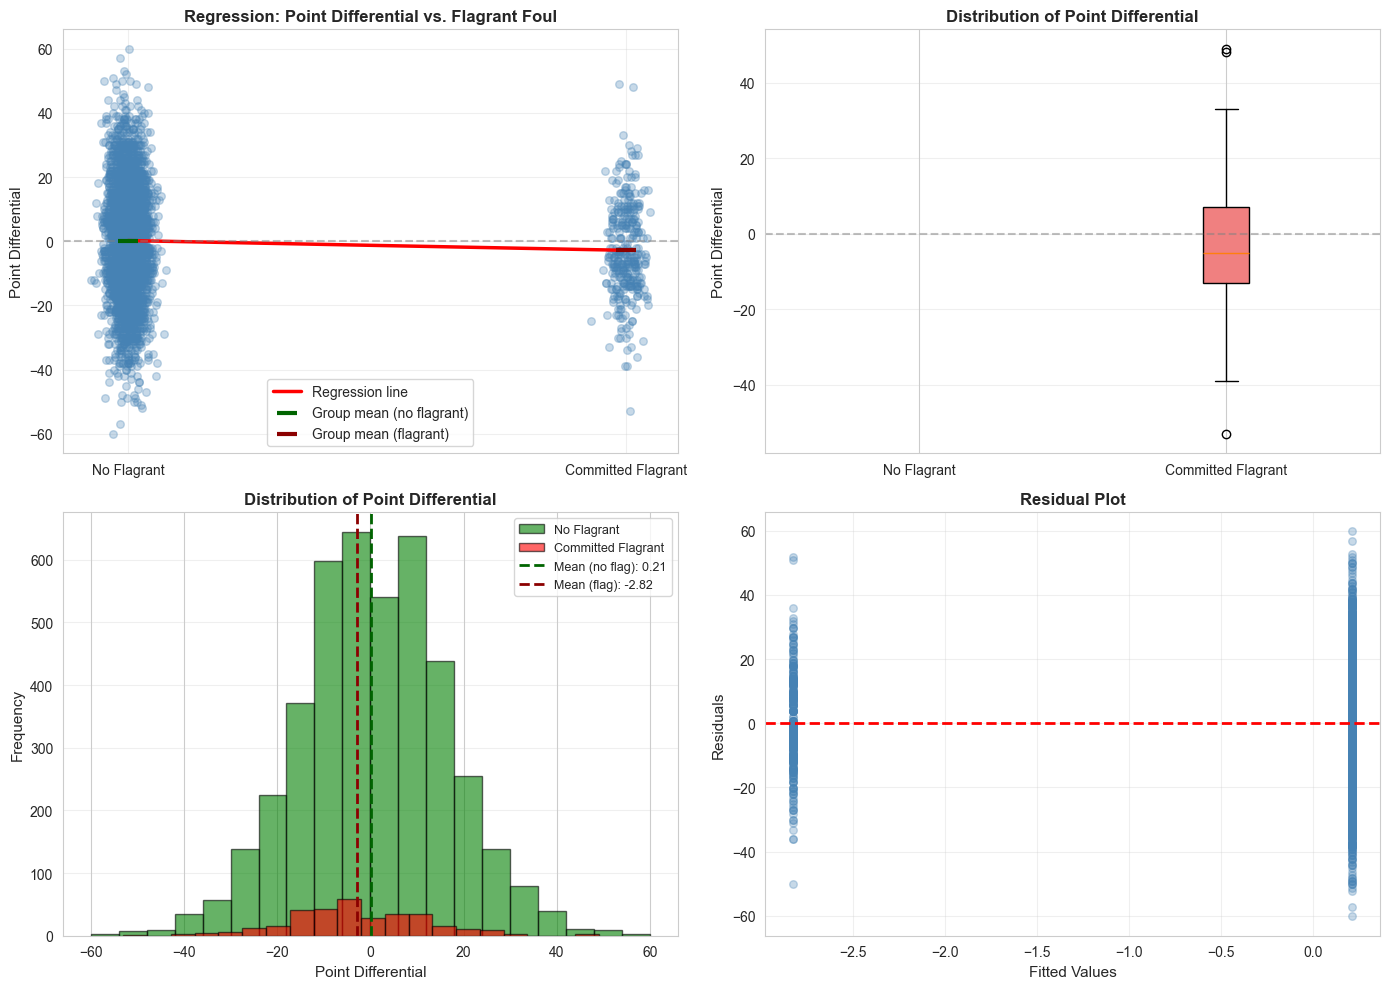

In [8]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scatter plot with regression line
ax1 = axes[0, 0]
x_jitter = df['committed_flagrant'] + np.random.normal(0, 0.02, len(df))
ax1.scatter(x_jitter, df['point_differential'], alpha=0.3, s=30, color='steelblue')

# Add regression line
x_line = np.array([0, 1])
y_line = intercept + flagrant_coef * x_line
ax1.plot(x_line, y_line, 'r-', linewidth=2.5, label=f'Regression line')

# Add group means
ax1.scatter([0], [mean_no_flagrant], color='darkgreen', s=200, marker='_', linewidth=3, label='Group mean (no flagrant)', zorder=5)
ax1.scatter([1], [mean_with_flagrant], color='darkred', s=200, marker='_', linewidth=3, label='Group mean (flagrant)', zorder=5)

ax1.set_xticks([0, 1])
ax1.set_xticklabels(['No Flagrant', 'Committed Flagrant'])
ax1.set_ylabel('Point Differential', fontsize=11)
ax1.set_title('Regression: Point Differential vs. Flagrant Foul', fontsize=12, fontweight='bold')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')

# 2. Box plot
ax2 = axes[0, 1]
data_for_box = [group1, group2]
bp = ax2.boxplot(data_for_box, labels=['No Flagrant', 'Committed Flagrant'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
ax2.set_ylabel('Point Differential', fontsize=11)
ax2.set_title('Distribution of Point Differential', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Histogram
ax3 = axes[1, 0]
ax3.hist(group1, bins=20, alpha=0.6, label='No Flagrant', color='green', edgecolor='black')
ax3.hist(group2, bins=20, alpha=0.6, label='Committed Flagrant', color='red', edgecolor='black')
ax3.axvline(mean_no_flagrant, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean (no flag): {mean_no_flagrant:.2f}')
ax3.axvline(mean_with_flagrant, color='darkred', linestyle='--', linewidth=2, label=f'Mean (flag): {mean_with_flagrant:.2f}')
ax3.set_xlabel('Point Differential', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Distribution of Point Differential', fontsize=12, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Residuals plot
ax4 = axes[1, 1]
predicted = model.fittedvalues
residuals = model.resid
ax4.scatter(predicted, residuals, alpha=0.3, s=30, color='steelblue')
ax4.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Fitted Values', fontsize=11)
ax4.set_ylabel('Residuals', fontsize=11)
ax4.set_title('Residual Plot', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary Table

In [9]:
# Clean summary table
summary_data = {
    'Variable': ['Committed Flagrant Foul'],
    'Coefficient': [f"{flagrant_coef:.4f}"],
    'Std. Error': [f"{flagrant_se:.4f}"],
    '95% CI': [f"[{flagrant_ci[0]:.4f}, {flagrant_ci[1]:.4f}]"],
    't-statistic': [f"{flagrant_coef/flagrant_se:.4f}"],
    'P-value': [f"{flagrant_pval:.4f}"],
    'Sig': ['*' if flagrant_pval < 0.05 else '']
}

summary_table = pd.DataFrame(summary_data)
print("\nSUMMARY TABLE:")
print(summary_table.to_string(index=False))
print("\nNote: * indicates p < 0.05")
print(f"\nModel: Point Differential = {intercept:.4f} + {flagrant_coef:.4f} * Committed_Flagrant")


SUMMARY TABLE:
               Variable Coefficient Std. Error             95% CI t-statistic P-value Sig
Committed Flagrant Foul     -3.0357     0.9115 [-4.8227, -1.2487]     -3.3304  0.0009   *

Note: * indicates p < 0.05

Model: Point Differential = 0.2118 + -3.0357 * Committed_Flagrant
